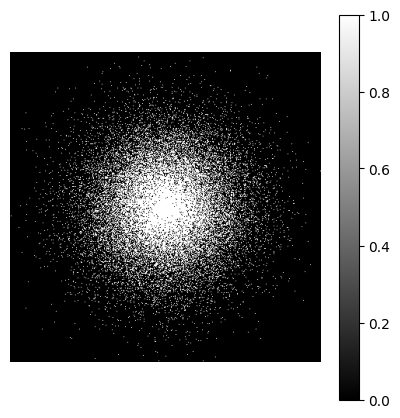

Iter 0: Loss = 110.4612
Iter 0: Gradient = 8.8424
data_term = 44.290990930817166
tv_term = 66.170178371293
Iter 50: Loss = 54.1355
Iter 50: Gradient = 1.1447
data_term = 18.36339676314756
tv_term = 35.7720786276736
Iter 100: Loss = 51.2204
Iter 100: Gradient = 0.5325
data_term = 16.965899462291706
tv_term = 34.2545253887316
Iter 150: Loss = 50.3062
Iter 150: Gradient = 0.3417
data_term = 16.377638639013885
tv_term = 33.928551564069195
Iter 200: Loss = 49.9127
Iter 200: Gradient = 0.2277
data_term = 16.096326668619287
tv_term = 33.81639898419951
Iter 250: Loss = 49.7296
Iter 250: Gradient = 0.1597
data_term = 15.955686564926388
tv_term = 33.7739285451248
Iter 300: Loss = 49.6379
Iter 300: Gradient = 0.1154
data_term = 15.878465878161345
tv_term = 33.75947258365221
Iter 350: Loss = 49.5877
Iter 350: Gradient = 0.0875
data_term = 15.833209643138716
tv_term = 33.754460120075116
Iter 400: Loss = 49.5577
Iter 400: Gradient = 0.0687
data_term = 15.80443110522381
tv_term = 33.7532230130028
Ite

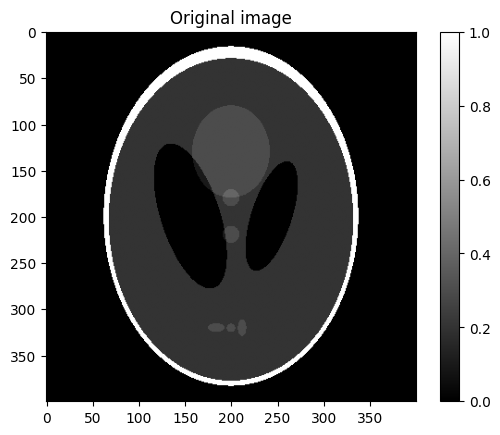

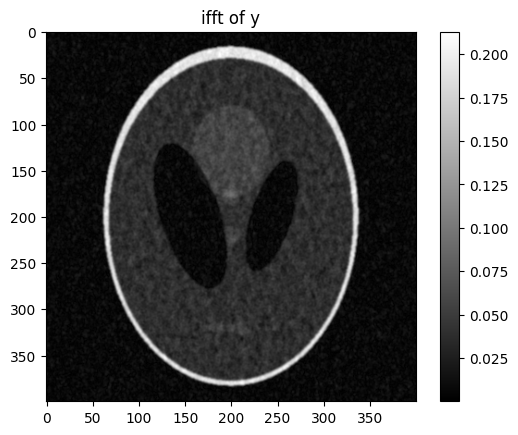

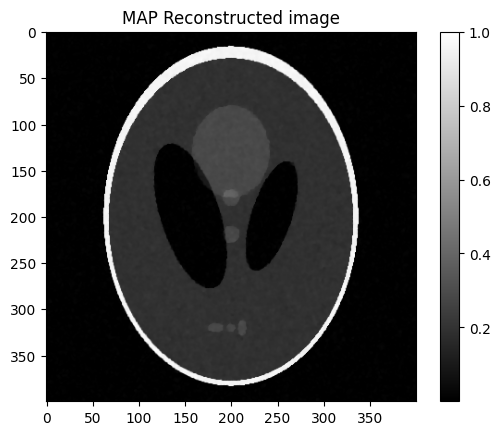

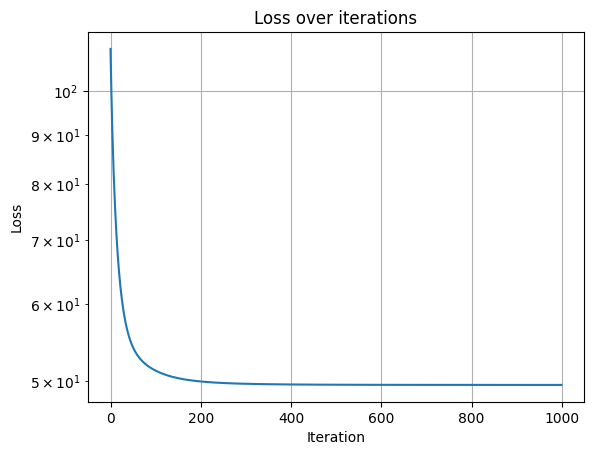

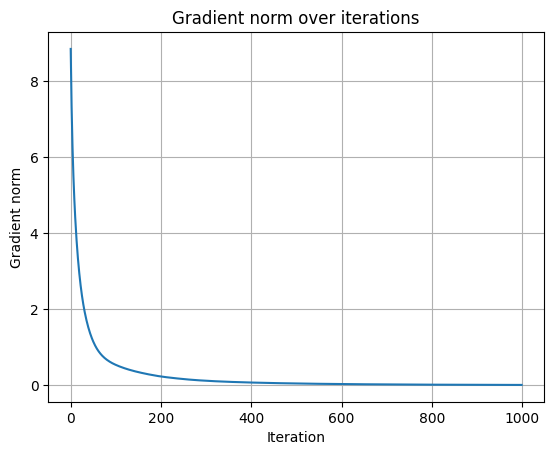

PSNR MAP: 33.54 dB, NMSE MAP: 0.0081, SSIM MAP: 0.8519
PSNR iFFT: 24.52 dB, NMSE iFFT: 0.0768, SSIM iFFT: 0.3308


In [8]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from utilities.masks import (
    PseudoRandomColumnMask,
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
    RadialMask
)
from utilities.metrics import ssim, nmse, psnr
from MAP.map_tv_minimize import MAPEstimator
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala_new import MMSEEstimatorMALA

# load image
shepp_logan = ski.data.shepp_logan_phantom() # has values [0,1]
# normalize image
# shepp_logan = shepp_logan / np.max(np.abs(shepp_logan))

# create mask (in the F domain)
bernoulli_mask = BernoulliMask(0.88, seed=30).generate(shepp_logan.shape)
centered_bernoulli_mask = CenteredBernoulliMask(0.5, 0.15, seed=30).generate(
    shepp_logan.shape
)
vd_mask = VariableDensityMask('gaussian', 0.2, seed=30).generate(shepp_logan.shape) # default used decay_param=0.3 - 0.5
pseudorand_mask = PseudoRandomColumnMask(shepp_logan.shape, 2, 1, seed=30).get_mask()
radial_mask = RadialMask(shepp_logan.shape, 60, 0.12).generate()

# the 'actual' measurement
vd_mask_shift_corrected = np.fft.fftshift(vd_mask)
sigma_noise = 0.05 # default 0.01
# Generate complex AWGN (MRI noise is complex Gaussian)
noise = (sigma_noise / np.sqrt(2)) * (
   np.random.randn(*shepp_logan.shape) + 1j * np.random.randn(*shepp_logan.shape)
)

# Mask must be applied to noise too — only sampled locations are noisy!!
#y = vd_mask_shift_corrected * (np.fft.fft2(shepp_logan, norm='ortho') + noise)
Fx = np.fft.fftshift(np.fft.fft2(shepp_logan, norm='ortho'))
y = vd_mask * (Fx + noise)


####################################################################
# mask
####################################################################

# plot mask
plt.figure(figsize=(5, 5))
plt.imshow(vd_mask, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.colorbar()
plt.axis('off')
plt.show()

####################################################################
# MAP
####################################################################

# given sigma=0.5 and norm='ortho'; L_data = 1/sigma² = 1/0.0025 = 400
# so: lr < 1/L meaning lr < 1/400 ≈ 2.5e-3 (safe) 

map_estimator = MAPEstimator(vd_mask, sigma_noise, 0.015, 1e-2, 0.1, 1000) # 0.1, 1e-2, 1e-3, 400

map_reconstruct = map_estimator.subgradient_descent(y)

# Target
plt.title("Original image")
plt.imshow(shepp_logan, cmap="gray")
plt.colorbar()
plt.show()  
# iFFT plot
plt.title("ifft of y")
plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho') / np.abs(np.fft.ifft(y, norm='ortho').max())), cmap="gray")
plt.colorbar()
plt.show()   
# MAP plot
plt.title("MAP Reconstructed image")
plt.imshow(np.abs(map_reconstruct) / np.abs(map_reconstruct.max()), cmap="gray")
plt.colorbar()
plt.show()

# MAP loss
plt.plot(map_estimator.loss_history)
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.yscale('log')
plt.show()

# MAP gradient
plt.plot(map_estimator.grad_norm_history)
plt.title("Gradient norm over iterations")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.grid(True)
#plt.yscale('log')
plt.show()

def evaluate_map(x_rec, x_ref):
    x_rec = np.abs(x_rec)
    x_ref = np.abs(x_ref)

    x_rec = x_rec / x_ref.max()
    x_ref = x_ref / x_ref.max()

    print(f"PSNR MAP: {psnr(x_rec, x_ref, data_range=1.0):.2f} dB, NMSE MAP: {nmse(x_rec, x_ref):.4f}, SSIM MAP: {ssim(x_rec, x_ref, data_range=1.0):.4f}")

evaluate_map(shepp_logan, map_reconstruct)

#####################################################################
# ULA 
#####################################################################
# ula_estimator = MMSEEstimatorULA(vd_mask_shift_corrected, sigma_noise, 0.1, 1e-2, 1e-8, 250, 2, 200) 

# samples, energies = ula_estimator.ula_sampling(y, x_init=map_reconstruct)
# ula_mmse = ula_estimator.compute_mmse_estimate(samples)

# # Target
# plt.title("Original image")
# plt.imshow(shepp_logan, cmap="gray")
# plt.colorbar()
# plt.show()  
# # iFFT plot
# plt.title("ifft of y")
# plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho') / np.abs(np.fft.ifft(y, norm='ortho').max())), cmap="gray")
# plt.colorbar()
# plt.show()   
# # ULA plot
# plt.title("ULA Reconstructed image")
# plt.imshow(np.abs(ula_mmse) / np.abs(ula_mmse.max()), cmap="gray")
# plt.colorbar()
# plt.show() 

# # ula energy
# plt.plot(energies)
# plt.title("ULA energy over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("ULA energy")
# plt.grid(True)
# #plt.yscale('log')
# plt.show()

# samples_array = np.array(samples)
# plt.hist(samples_array.ravel(), bins=200)
# plt.title("Histogram of sampled intensities")
# plt.show()

# psnr_ula = psnr(ula_mmse.real, shepp_logan) 
# nmse_ula = nmse(ula_mmse.real, shepp_logan)
# ssim_ula = ssim(ula_mmse.real, shepp_logan)
# print(f"PSNR ULA: {psnr_ula:.2f} dB, NMSE ULA: {nmse_ula:.4f}, SSIM ULA: {ssim_ula:.4f}")

#####################################################################
# MALA
#####################################################################
# mala_estimator = MMSEEstimatorMALA(vd_mask_shift_corrected, sigma_noise, 0.1, 1e-2, 1e4, 1000, 2, 300, beta=0.3) # used previously (0.005, 20*0.1, 1e-2, 1e-4, 350, 2, 200)

# # The right clip_grad value should be roughly sqrt(d) / sqrt(eta) ~ 256 / 0.01 = 25600 for noise-drift balance
# samples_kept, energies, step_trace, accept_trace = mala_estimator.mala_sampling(y, debug=True, freeze_L_after_burnin=True)
# mala_mmse = mala_estimator.compute_mmse_estimate(samples_kept)

# # Target
# plt.title("Original image")
# plt.imshow(shepp_logan, cmap="gray")
# plt.colorbar()
# plt.show()  
# # iFFT plot
# plt.title("ifft of y")
# plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho') / np.abs(np.fft.ifft(y, norm='ortho').max())), cmap="gray")
# plt.colorbar()
# plt.show()   
# # MALA plot
# plt.title("MALA Reconstructed image")
# plt.imshow(np.abs(mala_mmse) / np.abs(mala_mmse.max()), cmap="gray")
# plt.colorbar()
# plt.show() 
  
# # MALA graphs
# plt.figure(figsize=(14,6))
# plt.subplot(1,3,1)
# plt.plot(energies)
# plt.title('Energy trace')
# plt.xlabel("Iteration")
# plt.ylabel("MALA energy")
# plt.grid(True)
# plt.subplot(1,3,2)
# plt.plot(accept_trace / (np.arange(len(accept_trace))+1))
# plt.title('Cumulative accept rate')
# plt.subplot(1,3,3)
# plt.plot(step_trace)
# plt.title('Step size trace')
# plt.tight_layout()
# plt.show()

# psnr_mala = psnr(mala_mmse.real, shepp_logan) 
# nmse_mala = nmse(mala_mmse.real, shepp_logan)
# ssim_mala = ssim(mala_mmse.real, shepp_logan)
# print(f"PSNR MALA: {psnr_mala:.2f} dB, NMSE MALA: {nmse_mala:.4f}, SSIM MALA: {ssim_mala:.4f}")

def evaluate_ifft(x_rec, x_ref):
    x_rec = np.abs(x_rec)
    x_ref = np.abs(x_ref)

    x_rec = x_rec / x_ref.max()
    x_ref = x_ref / x_ref.max()

    print(f"PSNR iFFT: {psnr(x_rec, x_ref, data_range=1.0):.2f} dB, NMSE iFFT: {nmse(x_rec, x_ref):.4f}, SSIM iFFT: {ssim(x_rec, x_ref, data_range=1.0):.4f}")

evaluate_ifft(shepp_logan, np.abs(np.fft.ifft2(y, norm='ortho')))

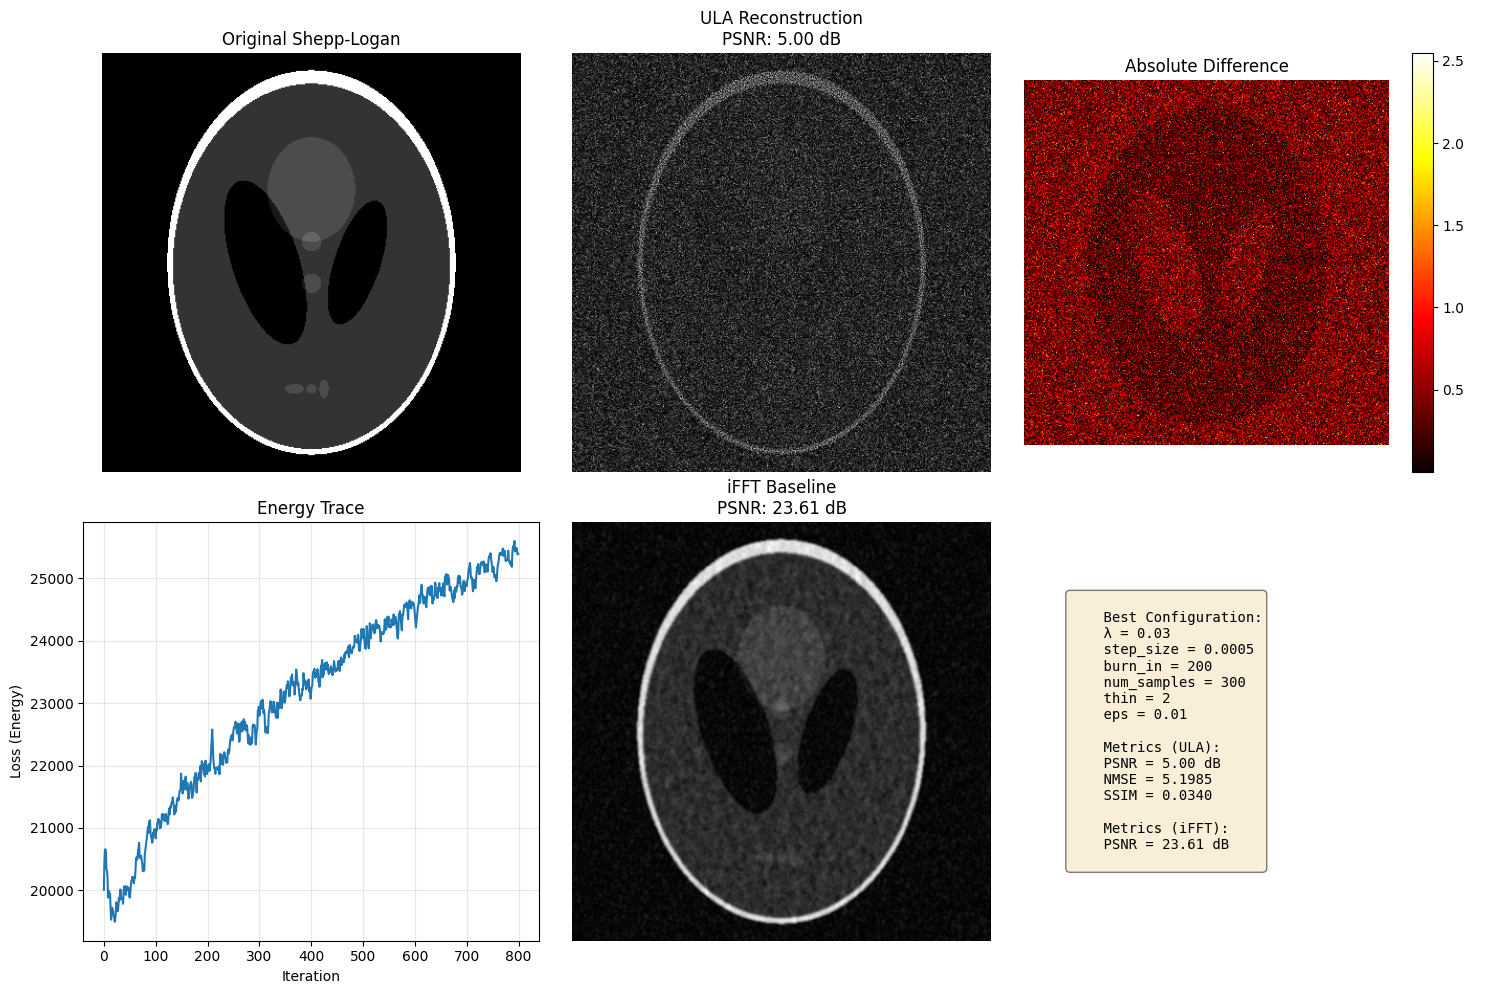

In [ ]:
# Visualize best result
def visualize_best_results(results_list):
    """Visualize original, reconstruction, and difference."""
    if not results_list:
        print("No results yet.")
        return
    
    # Find best by PSNR
    best_idx = max(range(len(results_list)), key=lambda i: results_list[i]['psnr'])
    best_result = results_list[best_idx]
    
    reconstruction = best_result['mmse_estimate']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original
    axes[0, 0].imshow(shepp_logan, cmap='gray')
    axes[0, 0].set_title('Original Shepp-Logan')
    axes[0, 0].axis('off')
    
    # Reconstruction
    axes[0, 1].imshow(np.abs(reconstruction), cmap='gray')
    axes[0, 1].set_title(f"ULA Reconstruction\nPSNR: {best_result['psnr']:.2f} dB")
    axes[0, 1].axis('off')
    
    # Difference
    diff = np.abs(shepp_logan - np.abs(reconstruction))
    im_diff = axes[0, 2].imshow(diff, cmap='hot')
    axes[0, 2].set_title('Absolute Difference')
    axes[0, 2].axis('off')
    plt.colorbar(im_diff, ax=axes[0, 2])
    
    # Energy trace
    axes[1, 0].plot(best_result['energies'])
    axes[1, 0].set_title('Energy Trace')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Loss (Energy)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # iFFT baseline
    ifft_result = np.abs(np.fft.ifft2(y, norm='ortho'))
    axes[1, 1].imshow(ifft_result / ifft_result.max(), cmap='gray')
    ifft_psnr = psnr(ifft_result, shepp_logan)
    axes[1, 1].set_title(f"iFFT Baseline\nPSNR: {ifft_psnr:.2f} dB")
    axes[1, 1].axis('off')
    
    # Metrics comparison
    axes[1, 2].axis('off')
    #results order
    metrics_text = f"""
    Best Configuration:
    λ = {best_result['lambda']}
    step_size = {best_result['step_size']}
    burn_in = {best_result['burn_in']}
    num_samples = {best_result['num_samples']}
    thin = {best_result['thin']}
    eps = {best_result['eps']}
    
    Metrics (ULA):
    PSNR = {best_result['psnr']:.2f} dB
    NMSE = {best_result['nmse']:.4f}
    SSIM = {best_result['ssim']:.4f}
    
    Metrics (iFFT):
    PSNR = {ifft_psnr:.2f} dB
    """
    axes[1, 2].text(0.1, 0.5, metrics_text, fontsize=10, family='monospace',
                    verticalalignment='center', bbox=dict(boxstyle='round', 
                    facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Run after optimization
results = [0.1, 1e-3, 200, 300, 2, 1e-2]

visualize_best_results(results)

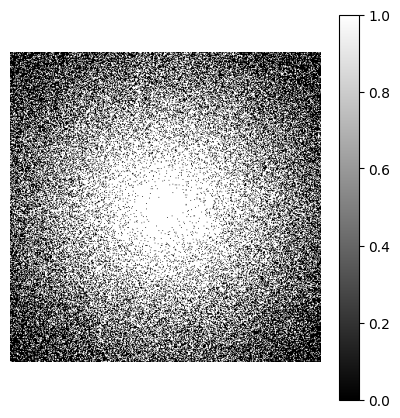

[MALA init]  U=1.1291e+03  ||g||=4.6116e+02
             L=1.0000e+04  drift=||g||/L=4.6116e-02
             noise=sqrt(2/L)*beta*sqrt(d)=2.7153e-01
[burn-in    0]  U=1.1220e+03  alpha=0.983  L=9.0909e+03  eta=1/L=1.1000e-04  acc_rate=1.000
[burn-in  100]  U=8.0143e+02  alpha=0.495  L=1.3513e+03  eta=1/L=7.4002e-04  acc_rate=0.673
[burn-in  200]  U=8.1089e+02  alpha=0.281  L=9.2296e+02  eta=1/L=1.0835e-03  acc_rate=0.627
[burn-in  300]  U=8.1143e+02  alpha=1.000  L=9.2296e+02  eta=1/L=1.0835e-03  acc_rate=0.598
[burn-in  400]  U=8.1847e+02  alpha=0.226  L=9.2296e+02  eta=1/L=1.0835e-03  acc_rate=0.599
Burn-in done.  accept_rate=0.5960  final L=8.3905e+02  eta=1/L=1.1918e-03
[avg       0]  U=8.1756e+02  alpha=0.434  L=8.3905e+02  acc_rate=0.000
[avg     100]  U=8.2202e+02  alpha=0.828  L=8.3905e+02  acc_rate=0.554
[avg     200]  U=8.0848e+02  alpha=0.025  L=8.3905e+02  acc_rate=0.562
[avg     300]  U=8.2419e+02  alpha=1.000  L=8.3905e+02  acc_rate=0.535
[avg     400]  U=8.1283e+02  alph

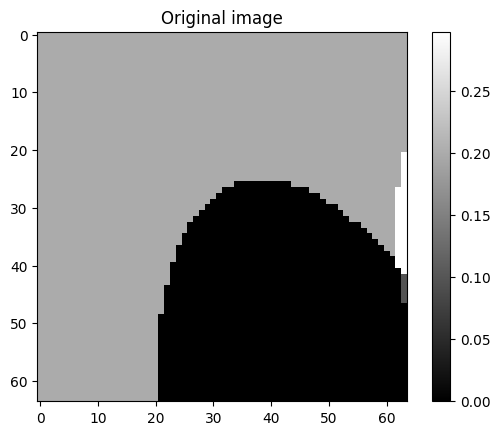

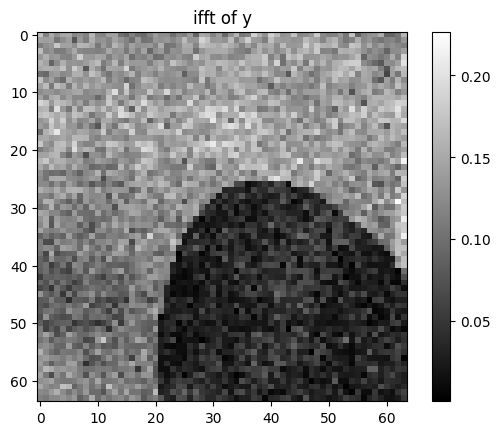

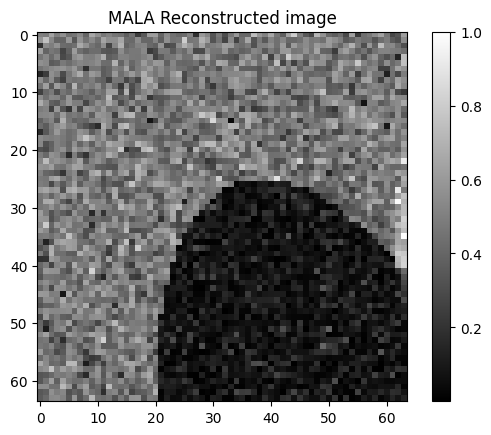

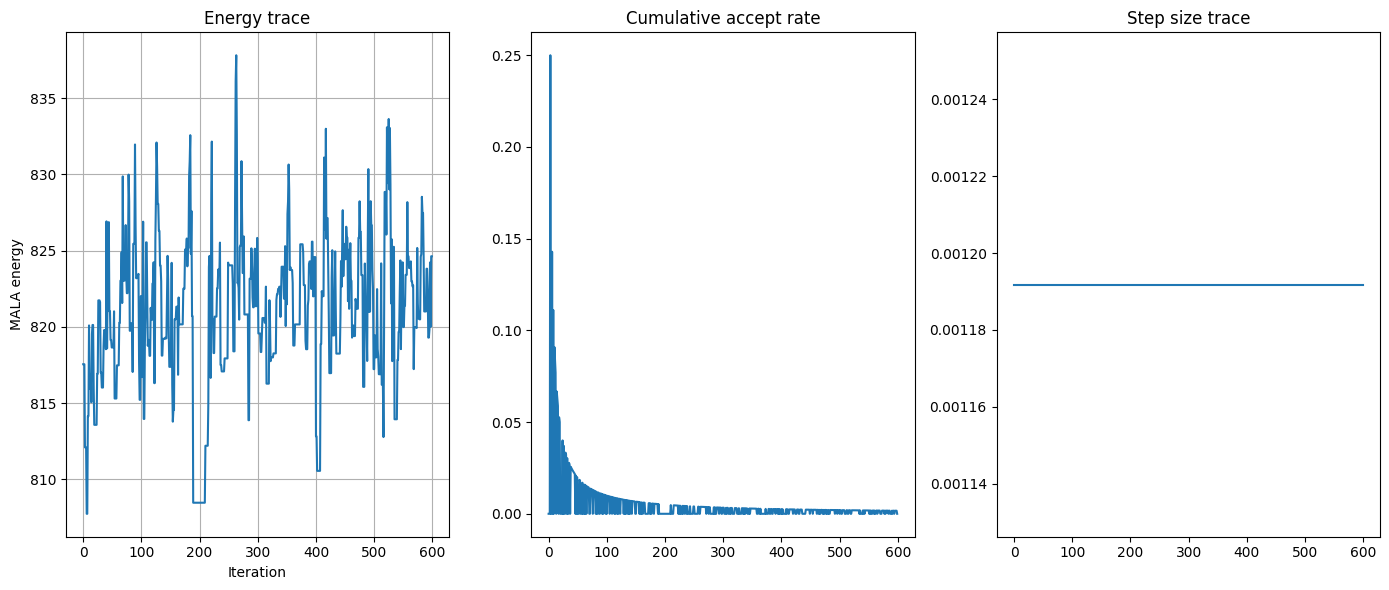

PSNR MALA: 18.69 dB, NMSE MALA: 0.0831, SSIM MALA: 0.1501
PSNR iFFT: 16.48 dB, NMSE iFFT: 0.0946, SSIM iFFT: 0.1616


In [ ]:
# smaller region test 64 x 64

import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from utilities.masks import (
    PseudoRandomColumnMask,
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
    RadialMask
)
from utilities.metrics import ssim, nmse, psnr
from MMSE.mmse_mala_new import MMSEEstimatorMALA
from MAP.map_tv_minimize import MAPEstimator

def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-12)

# load image
shepp_logan = ski.data.shepp_logan_phantom() # has values [0,1]

# create mask (in the F domain)
bernoulli_mask = BernoulliMask(0.88, seed=30).generate(shepp_logan.shape)
centered_bernoulli_mask = CenteredBernoulliMask(0.5, 0.15, seed=30).generate(
    shepp_logan.shape
)
vd_mask = VariableDensityMask('gaussian', 0.5, seed=30).generate(shepp_logan.shape) # default used decay_param=0.3 - 0.5
pseudorand_mask = PseudoRandomColumnMask(shepp_logan.shape, 2, 1, seed=30).get_mask()
radial_mask = RadialMask(shepp_logan.shape, 60, 0.12).generate()

# the 'actual' measurement
# Mask must be applied to noise too — only sampled locations are noisy!!
# Crop to 64x64 center patch
sl_small  = shepp_logan[96:160, 96:160]          # 64x64 center

sigma_noise = 0.05 # default 0.01
# Generate complex AWGN (MRI noise is complex Gaussian)
noise = (sigma_noise / np.sqrt(2)) * (
   np.random.randn(*sl_small.shape) + 1j * np.random.randn(*sl_small.shape)
)

M_small   = vd_mask[96:160, 96:160]
Fx = np.fft.fftshift(np.fft.fft2(sl_small, norm='ortho'))
y_small = M_small * (Fx + noise)
y_check = M_small * np.fft.fft2(sl_small, norm='ortho')


# plot mask
plt.figure(figsize=(5, 5))
plt.imshow(vd_mask, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.colorbar()
plt.axis('off')
plt.show()

####################################################################
# MAP
####################################################################

# given sigma=0.5 and norm='ortho'; L_data = 1/sigma² = 1/0.0025 = 400
# so: lr < 1/L meaning lr < 1/400 ≈ 2.5e-3 (safe) 

# map_estimator = MAPEstimator(M_small, sigma_noise, 0.015, 1e-2, 0.1, 500) # 0.1, 1e-2, 1e-3, 400

# map_reconstruct = map_estimator.subgradient_descent(y_small)

# # Target
# plt.title("Original image")
# plt.imshow(sl_small, cmap="gray")
# plt.colorbar()
# plt.show()  
# # iFFT plot
# plt.title("ifft of y")
# plt.imshow(np.abs(np.fft.ifft2(y_small, norm='ortho') / np.abs(np.fft.ifft(y_small, norm='ortho').max())), cmap="gray")
# plt.colorbar()
# plt.show()   
# # MAP plot
# plt.title("MAP Reconstructed image")
# plt.imshow(np.abs(map_reconstruct) / np.abs(map_reconstruct.max()), cmap="gray")
# plt.colorbar()
# plt.show()

# # MAP loss
# plt.plot(map_estimator.loss_history)
# plt.title("Loss over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.yscale('log')
# plt.show()

# # MAP gradient
# plt.plot(map_estimator.grad_norm_history)
# plt.title("Gradient norm over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Gradient norm")
# plt.grid(True)
# #plt.yscale('log')
# plt.show()

# psnr_map = psnr(map_reconstruct.real, sl_small) # .real because shepp-logan is also real-valued
# nmse_map = nmse(map_reconstruct.real, sl_small)
# ssim_map = ssim(map_reconstruct.real, sl_small)
# print(f"PSNR MAP: {psnr_map:.2f} dB, NMSE MAP: {nmse_map:.4f}, SSIM MAP: {ssim_map:.4f}")

#####################################################################
# MALA
#####################################################################
mala_estimator = MMSEEstimatorMALA(M_small, sigma_noise, 0.1, 1e-2, 1e4, 500, 2, 300, beta=0.3)

samples_kept, energies, step_trace, accept_trace = mala_estimator.mala_sampling(y_small, debug=True, freeze_L_after_burnin=True)
mala_mmse = mala_estimator.compute_mmse_estimate(samples_kept)

print("=== Scale diagnostics ===")
print(f"sl_small:   min={sl_small.min():.4f}  max={sl_small.max():.4f}  mean={sl_small.mean():.4f}")
print(f"mala_mmse:  min={mala_mmse.min():.4f}  max={mala_mmse.max():.4f}  mean={mala_mmse.mean():.4f}")
print(f"iFFT init:  ", end="")
x_init = np.real(np.fft.ifft2(y_small, norm='ortho'))
print(f"min={x_init.min():.4f}  max={x_init.max():.4f}  mean={x_init.mean():.4f}")

print("\n=== Mask diagnostics ===")
print(f"M_small sum (sampled freqs): {M_small.sum():.0f} / {M_small.size} = {M_small.mean():.2%}")
print(f"DC component sampled (M_small[0,0]): {M_small[0,0]}")  # 1=yes, 0=no

print("\n=== Forward model check ===")
# Reconstruct from full k-space (no mask) — should be near-perfect
y_full = np.fft.fft2(sl_small, norm='ortho')
x_recon_full = np.real(np.fft.ifft2(y_full, norm='ortho'))
print(f"ifft2(fft2(sl_small)) max error: {np.abs(x_recon_full - sl_small).max():.2e}  (should be ~1e-14)")

# Reconstruct from masked k-space — shows what zero-fill gives
y_masked = M_small * y_full
x_recon_masked = np.real(np.fft.ifft2(y_masked, norm='ortho'))
from skimage.metrics import peak_signal_noise_ratio as psnr_sk
print(f"iFFT of masked y PSNR: {psnr_sk(sl_small, x_recon_masked, data_range=sl_small.max()-sl_small.min()):.2f} dB")

print("\n=== y_small check ===")
print(f"y_small constructed from sl_small directly? ", end="")
y_check = M_small * np.fft.fft2(sl_small, norm='ortho')
print(f"max diff from y_small: {np.abs(y_check - y_small).max():.2e}  (should be ~0)")

print(f"sl_small mean={sl_small.mean():.4f}")
x_init = np.real(np.fft.ifft2(y_small, norm='ortho'))
print(f"iFFT init mean={x_init.mean():.4f}")                 # should now match sl_small mean

# Target
plt.title("Original image")
plt.imshow(sl_small, cmap="gray")
plt.colorbar()
plt.show()  
# iFFT plot
plt.title("ifft of y")
plt.imshow(np.abs(np.fft.ifft2(y_small, norm='ortho') / np.abs(np.fft.ifft(y_small, norm='ortho').max())), cmap="gray")
plt.colorbar()
plt.show()   
# MALA plot
plt.title("MALA Reconstructed image")
plt.imshow(np.abs(mala_mmse) / np.abs(mala_mmse.max()), cmap="gray")
plt.colorbar()
plt.show() 
  
# MALA graphs
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.plot(energies)
plt.title('Energy trace')
plt.xlabel("Iteration")
plt.ylabel("MALA energy")
plt.grid(True)
plt.subplot(1,3,2)
plt.plot(accept_trace / (np.arange(len(accept_trace))+1))
plt.title('Cumulative accept rate')
plt.subplot(1,3,3)
plt.plot(step_trace)
plt.title('Step size trace')
plt.tight_layout()
plt.show()

def evaluate_mala(x_rec, x_ref):
    x_rec = np.abs(x_rec)
    x_ref = np.abs(x_ref)

    x_rec = x_rec / x_ref.max()
    x_ref = x_ref / x_ref.max()

    print(f"PSNR MALA: {psnr(x_rec, x_ref, data_range=1.0):.2f} dB, NMSE MALA: {nmse(x_rec, x_ref):.4f}, SSIM MALA: {ssim(x_rec, x_ref, data_range=1.0):.4f}")

evaluate_mala(sl_small, mala_mmse)

def evaluate_ifft(x_rec, x_ref):
    x_rec = np.abs(x_rec)
    x_ref = np.abs(x_ref)

    x_rec = x_rec / x_ref.max()
    x_ref = x_ref / x_ref.max()

    print(f"PSNR iFFT: {psnr(x_rec, x_ref, data_range=1.0):.2f} dB, NMSE iFFT: {nmse(x_rec, x_ref):.4f}, SSIM iFFT: {ssim(x_rec, x_ref, data_range=1.0):.4f}")

evaluate_ifft(sl_small, np.fft.ifft2(y_small, norm='ortho'))